In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

In [22]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df = pd.read_csv('/content/BLOOM Historical Data_Cleaned.csv', usecols=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df.asfreq('B')

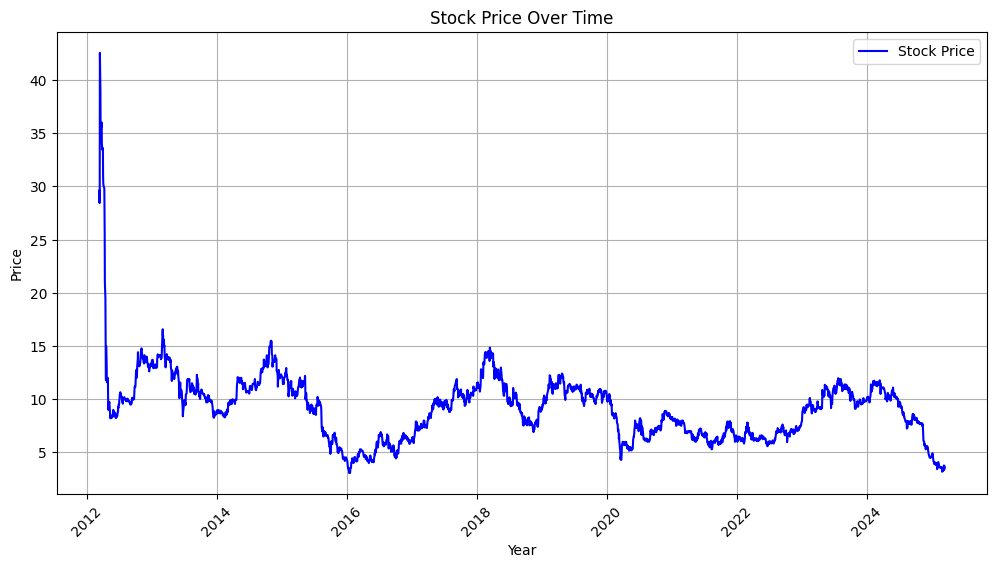

In [23]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label="Stock Price", color='blue')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Stock Price Over Time")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid()
plt.show()

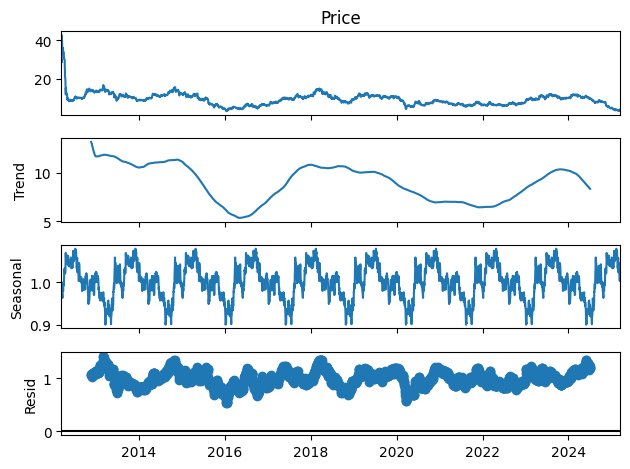

In [24]:
results = seasonal_decompose(df['Price'], model='multiplicative', period=365)
results.plot()
plt.show()

In [25]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

In [26]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [27]:
scaled_train = np.array(scaled_train).reshape(-1, 1)
scaled_val = np.array(scaled_val).reshape(-1, 1)
scaled_test = np.array(scaled_test).reshape(-1, 1)

In [28]:
n_input = 90
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)

In [29]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 90, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
checkpoint = ModelCheckpoint("BLOOM_model.h5", save_best_only=True, monitor='val_loss', mode='min')

In [31]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping, checkpoint])

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2626/2626 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 9.4821e-04

2626/2626 ━━━━━━━━━━━━━━━━━━━━ 139s 52ms/step - loss: 9.4802e-04 - val_loss: 4.4509e-04
Epoch 2/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.4921e-04

2626/2626 ━━━━━━━━━━━━━━━━━━━━ 135s 51ms/step - loss: 2.4921e-04 - val_loss: 7.8296e-05
Epoch 3/30
2625/2626 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 1.9610e-04

2626/2626 ━━━━━━━━━━━━━━━━━━━━ 134s 51ms/step - loss: 1.9610e-04 - val_loss: 6.7323e-05
Epoch 4/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.8484e-04

2626/2626 ━━━━━━━━━━━━━━━━━━━━ 146s 56ms/step - loss: 1.8484e-04 - val_loss: 5.8087e-05
Epoch 5/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 135s 52ms/step - loss: 1.4942e-04 - val_loss: 6.6920e-05
Epoch 6/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 145s 53ms/step - loss: 1.5409e-04 - val_loss: 6.0447e-05
Epoch 7/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 140s 53ms/step - loss: 1.4757e-04 - val_loss: 1.5057e-04
Epoch 8/30
2625/2626 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.3487e-04

2626/2626 ━━━━━━━━━━━━━━━━━━━━ 139s 53ms/step - loss: 1.3487e-04 - val_loss: 4.5115e-05
Epoch 9/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 1.3019e-04

2626/2626 ━━━━━━━━━━━━━━━━━━━━ 139s 53ms/step - loss: 1.3019e-04 - val_loss: 3.5237e-05
Epoch 10/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 141s 52ms/step - loss: 1.2132e-04 - val_loss: 3.6643e-05
Epoch 11/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 141s 54ms/step - loss: 1.2279e-04 - val_loss: 8.8205e-05
Epoch 12/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 141s 54ms/step - loss: 1.2847e-04 - val_loss: 4.6183e-05
Epoch 13/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.2069e-04

2626/2626 ━━━━━━━━━━━━━━━━━━━━ 142s 54ms/step - loss: 1.2069e-04 - val_loss: 3.4846e-05
Epoch 14/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 139s 53ms/step - loss: 1.1226e-04 - val_loss: 4.4728e-05
Epoch 15/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 138s 53ms/step - loss: 1.1499e-04 - val_loss: 5.3218e-05
Epoch 16/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 138s 53ms/step - loss: 1.0276e-04 - val_loss: 5.7533e-05
Epoch 17/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 140s 53ms/step - loss: 9.6894e-05 - val_loss: 6.8779e-05
Epoch 18/30
2626/2626 ━━━━━━━━━━━━━━━━━━━━ 139s 53ms/step - loss: 1.0653e-04 - val_loss: 1.1858e-04


In [32]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model.save("BLOOM_Model.h5")

In [33]:
full_scaled = scaler.transform(df)
full_scaled = np.array(full_scaled).reshape(-1, 1)
first_eval_batch = full_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

future_steps = 7
future_predictions = []

for i in range(future_steps):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [34]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [35]:
actual_recent = df.tail(23)

In [36]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_steps, freq='B')

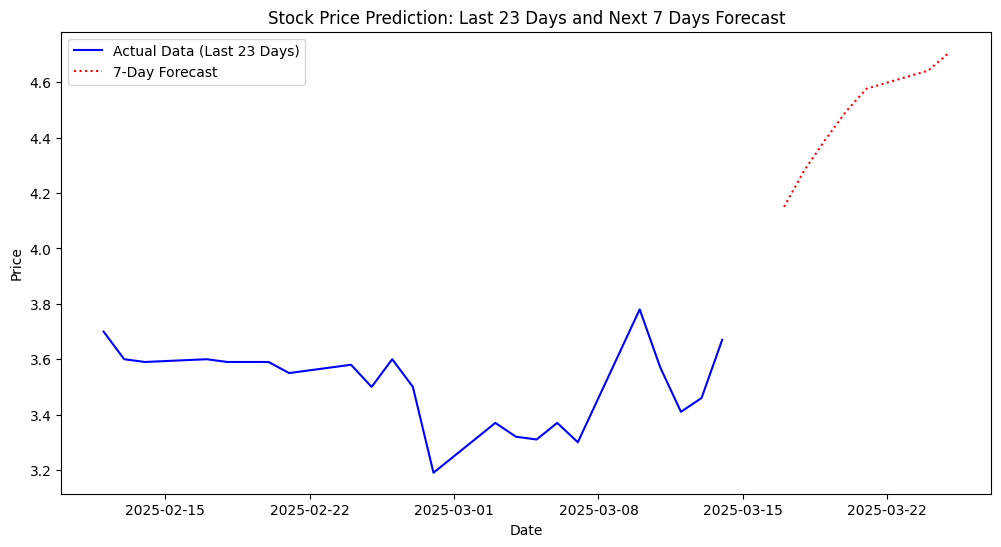

In [37]:
plt.figure(figsize=(12, 6))
plt.plot(actual_recent.index, actual_recent['Price'], label='Actual Data (Last 23 Days)', color='blue')
plt.plot(future_dates, future_predictions, linestyle='dotted', color='red', label='7-Day Forecast')
plt.legend()
plt.title("Stock Price Prediction: Last 23 Days and Next 7 Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [38]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions.flatten()
})

In [39]:
forecast_df.to_csv('BLOOM_predictions.csv', index=False)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("Future predictions saved to 'future_predictions.csv'.")

Future predictions saved to 'future_predictions.csv'.
